# Predict Credit Card Default

by Brenda Zhang


### Summary

The goal of this analysis is to build a model to predict the likelihood of default based on customer default payments data in Taiwan (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#). The analysis includes exploratory data analysis, preprocessing, and multiple machine learning model training, tuning and comparison.

- Given that the dataset is imbalanced, we use AUC as the evaluation metric.
- We use median values to impute missing values of continuous features and then standardize them. We apply one-hot encoding to categorical features.
- We compare Logisitic Regression, Random Forest, and XGBoost and find that the __XGBoost model__ performs the best in the training set and select it as the final model.
- The final model gets an AUC of 0.8284 in the training set and an AUC of 0.7763 in the test set.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

plt.style.use('ggplot')

# Set constant variables
RANDOM_SEED = 7
N_FOLDS = 5
TEST_SIZE = 0.2
N_JOBS = -1

### Load Dataset

Load input data using Excel file "default of credit card clients.xls" from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

In [2]:
cc_data = pd.read_excel('default of credit card clients.xls', header = [1])
cc_data = cc_data.rename(columns={'default payment next month': 'default_flag'})

### Exploratory Data Analysis

Variable defitions: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.


Note that:
- Categorical variables such as Gender, Education and Marital status have zero values, we assume those are NULL values.

Get data type information as well as sample size.

In [3]:
cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            30000 non-null  int64
 1   LIMIT_BAL     30000 non-null  int64
 2   SEX           30000 non-null  int64
 3   EDUCATION     30000 non-null  int64
 4   MARRIAGE      30000 non-null  int64
 5   AGE           30000 non-null  int64
 6   PAY_0         30000 non-null  int64
 7   PAY_2         30000 non-null  int64
 8   PAY_3         30000 non-null  int64
 9   PAY_4         30000 non-null  int64
 10  PAY_5         30000 non-null  int64
 11  PAY_6         30000 non-null  int64
 12  BILL_AMT1     30000 non-null  int64
 13  BILL_AMT2     30000 non-null  int64
 14  BILL_AMT3     30000 non-null  int64
 15  BILL_AMT4     30000 non-null  int64
 16  BILL_AMT5     30000 non-null  int64
 17  BILL_AMT6     30000 non-null  int64
 18  PAY_AMT1      30000 non-null  int64
 19  PAY_AMT2      30000 non-n

Overview of the dataset

In [4]:
cc_data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_flag
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Plot the distribution of the target.

<ipython-input-5-274cc515e52e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in yticks])


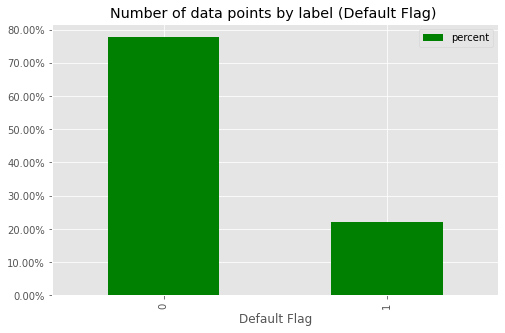

In [5]:
# Drop NAs from the dataset
cc_data.dropna(inplace=True)

cnt_by_flag = cc_data.groupby('default_flag').size().reset_index()
cnt_by_flag['all_class'] = cc_data['default_flag'].count()
cnt_by_flag['percent'] = cnt_by_flag[0]/cnt_by_flag['all_class']
format_dict = {'percent': '{:.2%}'}

# Plot the number of data points by label value
fig, ax = plt.subplots(figsize =(8,5))
cnt_by_flag.plot(x='default_flag', y='percent', kind='bar', ax=ax, color='green')
yticks = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in yticks])
plt.title("Number of data points by label (Default Flag) ")
plt.xlabel("Default Flag")
plt.show()

The distribution shows that the dataset is imbalanced. Most of the samples are with negative labels.

Given an imbalanced dataset, we choose to use AUC as the evaluation metric, instead of accuracy score.

### More Exploratory Analysis

Plot the distribution of categorical variables and their average default percentages.

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


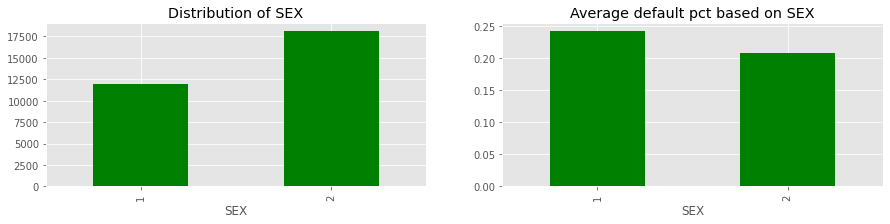

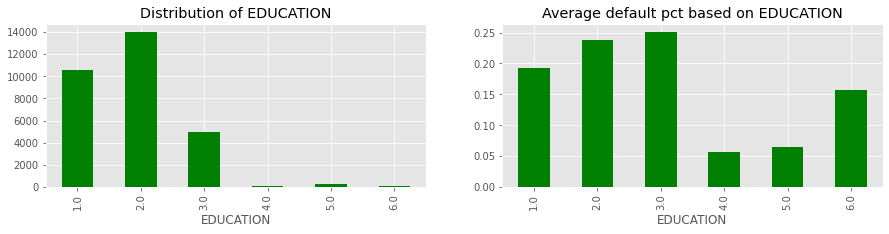

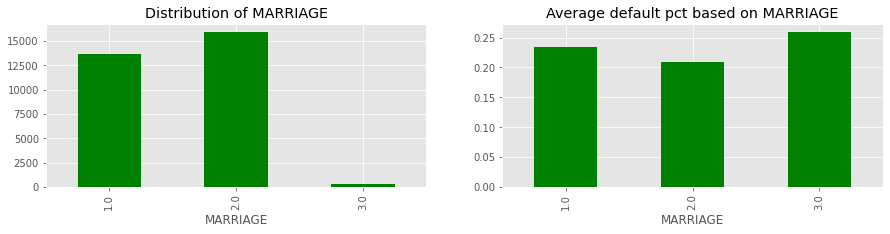

In [6]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
# Fill 0 with np.nan
for col in categorical_features:
    cc_data[col] = cc_data[col].replace(0, np.nan)

def plot_categorical(feature):
    fig, ax = plt.subplots(1, 2, figsize =(15,3))
    cc_data.groupby(feature)['default_flag'].size().plot(kind='bar', color='green', ax=ax[0])
    cc_data.groupby(feature)['default_flag'].mean().plot(kind='bar', color='green', ax=ax[1])
    ax[0].set_title('Distribution of {}'.format(feature))
    ax[1].set_title('Average default pct based on {}'.format(feature))
    plt.show()
    

for feature in categorical_features:
    plot_categorical(feature)

### Modeling: Preprocessing 

Divide data in to Train and Test set.

The test set is to evaluate if the final model selected is generalizable and will only be used once the best model is selected.

In [7]:
continuous_features = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
features = categorical_features + continuous_features
target = 'default_flag'
cc_data.dropna(subset=features, inplace=True)

X = cc_data[features]
y = cc_data[target].values
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, 
                                                                    random_state=RANDOM_SEED, 
                                                                    test_size=TEST_SIZE)

### Modeling: Model Formulation and Selection

We use median values to impute missing values of continuous features and standardize them. We apply one-hot encoding to categorical features.


We train and tune four machine learning models/implementations: Logistic Regression, Random Forest, and XGBoost.

In [8]:
def get_model(estimator):
    """
    Build model pipeline with feature transformation and estimator
    """
    continuous_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='median')),
                                           ('scaler', StandardScaler())])
    preprocessing = ColumnTransformer(
                    transformers=[
                                  ('continuous', continuous_transformer, continuous_features),
                                  ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)
                    ])
    model_pipeline = Pipeline([('transformer', preprocessing),
                               ('estimator', estimator)])
    return model_pipeline

#### Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
model_lr = get_model(lr)

In [10]:
param_grid_lr = {
                'estimator__C': np.logspace(-3, 3, 10)
                }
search_lr = GridSearchCV(model_lr, param_grid_lr, n_jobs=-1, scoring='roc_auc', cv=N_FOLDS)
print("Fitting and search for best LR model.")
search_lr.fit(X_train_all, y_train_all)

print("\nBest LR Estimator:")
print(search_lr.best_estimator_['estimator'])

# Best LR Model Scores
train_scores_lr = roc_auc_score(y_train_all, search_lr.predict_proba(X_train_all)[:, 1])
print("\nBest LR train AUC: {}".format(train_scores_lr))

Fitting and search for best LR model.

Best LR Estimator:
LogisticRegression(C=10.0, max_iter=10000)

Best LR train AUC: 0.7266347500234124


#### Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
estimator_rf = RandomForestClassifier()
model_rf = get_model(estimator_rf)

In [12]:
param_grid_rf = {
                'estimator__n_estimators': [50, 100, 200, 500],
                'estimator__max_features': ['auto', 'sqrt', 'log2'],
                'estimator__max_depth': [2, 3, 5, 8]
                }
search_rf = GridSearchCV(model_rf, param_grid_rf, n_jobs=-1, scoring='roc_auc')
print("Fitting and search for best RF model.")
search_rf.fit(X_train_all, y_train_all)

print("\nBest RF Estimator:")
print(search_rf.best_estimator_['estimator'])

# Best RF Model Scores
train_scores_rf = roc_auc_score(y_train_all, search_rf.predict_proba(X_train_all)[:, 1])
print("\nBest RF train AUC: {}".format(train_scores_rf))

Fitting and search for best RF model.

Best RF Estimator:
RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=200)

Best RF train AUC: 0.8180044543596274


#### XGBoost

In [15]:
from xgboost import XGBClassifier
estimator_xgb = XGBClassifier(objective= 'binary:logistic', nthread=4)
model_xgb = get_model(estimator_xgb)

In [16]:
param_grid_xgb = {
                'estimator__n_estimators': [50, 100, 200],
                'estimator__max_depth': [2, 3, 5],
                'estimator__learning_rate': np.logspace(-2, 0, 5),
                }
search_xgb = GridSearchCV(model_xgb, param_grid_xgb, n_jobs=-1, scoring='roc_auc', verbose=3)
print("Fitting and search for best XGBoost model.")
search_xgb.fit(X_train_all, y_train_all)

print("Best XGBoost Estimator:")
print(search_xgb.best_estimator_['estimator'])

# Best XGB Model Scores
train_scores_xgb = roc_auc_score(y_train_all, search_xgb.predict_proba(X_train_all)[:, 1])
print("Best XGBoost train AUC: {}".format(train_scores_xgb))

Fitting and search for best XGBoost model.
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:19:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best XGBoost Estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03162277660168379,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best XGBoost train AUC: 0.828422393

#### Model Comparison & Selection

According to cross-validation performance (AUC):

- the Logistic Regression model: 0.7266
- the Random Forest model: 0.8180
- the XGBoost model: 0.8284

, we choose the __XGBoost model (learning_rate=0.0316, max_depth=5, n_estimators=200)__ as the final model.

### Model Evaluation

Run best models on the test set and evaluate the model performance. The chosen model has an AUC of 0.7763. The test performance is slightly worse than the training set and the model overfits. 

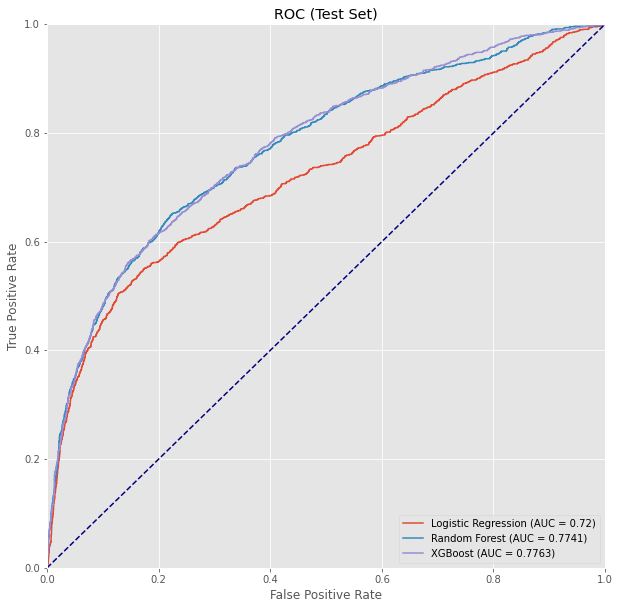

In [20]:
def plot_roc_auc(model_dict):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for model in model_dict.keys():
        fpr, tpr, _ = roc_curve(y_test_all, model_dict[model].predict_proba(X_test_all)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1.5, label='{} (AUC = {})'.format(model, round(roc_auc,4)))
    plt.plot([0,1], [0,1], color='navy', lw=1.5, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC (Test Set)')
    plt.legend(loc='lower right')
    plt.show()

model_dict = {'Logistic Regression': search_lr,
             'Random Forest': search_rf,
             'XGBoost': search_xgb}
plot_roc_auc(model_dict)

### Store Best Model to JOBLIB

In [18]:
import joblib
joblib.dump(search_xgb.best_estimator_, 'model.joblib')

['model.joblib']